In [2]:
import numpy as np
import networkx as nx
import som_functions as som
import math
import sklearn.metrics as met
import sklearn.manifold as man
from time import time

# ##function to return all connected components
# def connected_components(G):
    
#     #number of nodes in the graph
#     n = nx.number_of_nodes(G)
    
#     #adjacency matrix
#     A = nx.adjacency_matrix(G).toarray()
    
#     #list of degrees
#     deg = np.sum(A, axis=1)
    
#     #normalised graph laplacian
#     N = np.identity(n) - np.dot(np.dot(np.diag(deg ** -0.5), A), np.diag(deg ** -0.5))
    
#     #eigen decompose normalised laplacian
#     l, U = np.linalg.eigh(N)
    
#     ##sort eigenvalues (and eigenvectors) into ascending order
#     idx = l.argsort()
#     l = l[idx]
#     U = U[:,idx]
    
#     num_connected_components = len(l[l<1e-12])
    
#     connected_graphs = []
    
#     for i in range(num_connected_components):
        
#         ids = U[:,i].nonzero()[0]
        
#         H = G.subgraph([G.nodes()[n] for n in ids])
#         nx.set_node_attributes(H, 'connected_component', i)
        
#         connected_graphs.append(G.subgraph([G.nodes()[n] for n in ids]))
        
#     return connected_graphs

##floyds embedding
def floyd_embedding(G):
    
    n = len(G)
    
    fl = nx.floyd_warshall(G)
    
    #intitialise distance matrix
    D = np.zeros((n, n))
    
    #find closest k neighbours
    for i in range(n):
        n1 = G.nodes()[i]
        for j in range(n):
            n2 = G.nodes()[j]
            D[i,j] = fl[n1][n2]
    
    C = np.identity(n) - np.ones((n, n)) / n
    
    #similarity matrix
    K = - 1/2 * np.dot(np.dot(C, D ** 2), C)
    
    #eigen decompose K
    l, U = np.linalg.eigh(K)
    
    ##sort eigenvalues (and eigenvectors) into ascending order
    idx = l.argsort()[::-1]
    l = l[idx]
    U = U[:,idx]
    
    s = sum(l)
    
    k = len(l)
    var = 1
    
    while var > 0.95:
        k -= 1
        var = sum(l[:k]) / s
    
    k += 1
    
    #position matrix
    X = np.dot(U[:,:k], np.diag(l[:k] ** 0.5))
    
    return X

##function to generate benchmark graph
def benchmark_hierarchical_graph(edge_path, c1_path, c2_path):

    #construct graph from edge list
    G = nx.read_edgelist(edge_path)

    #create dictionarys of attributes
    c1 = read_attributes(c1_path)
    c2 = read_attributes(c2_path)

    #set attributes of G
    nx.set_node_attributes(G, 'firstlevelcommunity', c1)
    nx.set_node_attributes(G, 'secondlevelcommunity', c2)
    
    #return graph
    return G

##function to generate benchmark graph
def benchmark_graph(edge_path, c_path):
    
    #construct graph from edge list
    G = nx.read_edgelist(edge_path)

    #create dictionarys of attributes
    c = read_attributes(c_path)

    #set attributes of G
    nx.set_node_attributes(G, 'firstlevelcommunity', c)
    
    #return graph
    return G

##function to read in attributes from file and return a dictionary
def read_attributes(filepath):
    
    #initialise dictionary
    d = {}
    
    #open file
    with open(filepath) as f:
        
        #iterate over lines in f
        for l in f:
            
            #separate into key and value
            k, v = l.split()
            
            #add to dictionary
            d[k] = v
    
    #return
    return d

##save embedding to graph
def set_embedding(G, X):
    
    #get number of niodes in the graph
    num_nodes = nx.number_of_nodes(G)
    
    #dimension of embedding
    d = len(X[0])
    
    #iterate over a;; the nodes and save their embedding
    for i in range(num_nodes):
        for j in range(d):
            G.node[G.nodes()[i]]['embedding'+str(j)] = X[i,j]    

def main_hierarchical(network, first_level, second_level):
    
    #import graph from file
    G = benchmark_hierarchical_graph(network, first_level, second_level)
    
    #only embed largest subgraph
    H = max(nx.connected_component_subgraphs(G), key=len)
    
    #embed into X
    X = floyd_embedding(H)
    
    #save embedding to nodes of G
    set_embedding(H, X)
    
    #write gml file
    nx.write_gml(H, 'embedded_network_{}.gml'.format(network.split('_')[0]))

def main_binary(network, first_level, gml_filename):
    
    #import graph from file
    G = benchmark_graph(network, first_level)
    
    #only embed largest subgraph
    H = max(nx.connected_component_subgraphs(G), key=len)
    
    #embed into X
    X = floyd_embedding(H)
    
    #save embedding to nodes of G
    set_embedding(H, X)
    
    #write gml file
    nx.write_gml(H, gml_filename)

def main(txt, gml_filename):
    
    #import graph from file
    G = nx.read_edgelist(txt)
    
    #only embed largest subgraph
    H = max(nx.connected_component_subgraphs(G), key=len)
    
    #embed into X
    X = floyd_embedding(H)
    
    #save embedding to nodes of G
    set_embedding(H, X)
    
    #write gml file
    nx.write_gml(H, gml_filename)

In [8]:
# #import graph from file
# # G = benchmark_hierarchical_graph('1_network.dat', '1_community_first_level.dat', '1_community_second_level.dat')
# G = nx.karate_club_graph()

# #only embed largest subgraph
# H = max(nx.connected_component_subgraphs(G), key=len)

# #embed into X
# X = floyd_embedding(H)

<IPython.core.display.Javascript object>


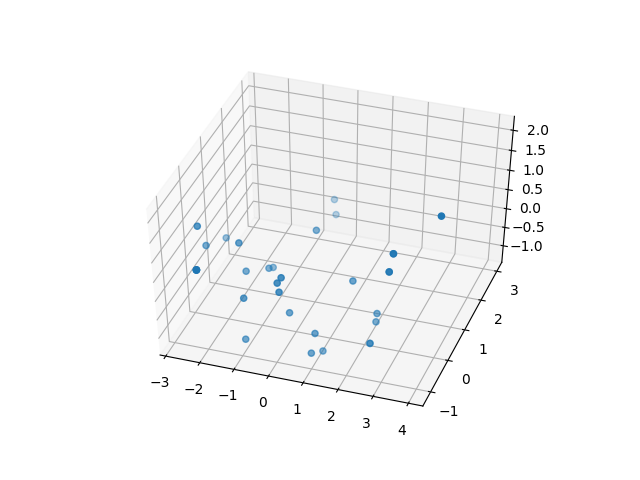

In [9]:
# %matplotlib notebook

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:,0], X[:,1], X[:,2])
# plt.show()

In [3]:
# # generate graph
# # # G = nx.karate_club_graph()
# G = nx.read_gml('football.gml')
# # # G = nx.read_gml('adjnoun.gml')
# G = nx.read_gml('dolphins_labelled.gml')
# # # G = nx.read_gml('polbooks.gml')
# # # G = benchmark_graph('bin_network.dat', 'community.dat')
# # # G = benchmark_hierarchical_graph('network.dat', 
# # #                                  'community_first_level.dat', 
# # #                                  'community_second_level.dat')
# # # G = benchmark_hierarchical_graph('literature_network.dat', 
# # #                                  'literature_community_first_level.dat', 
# # #                                  'literature_community_second_level.dat')
# # # G = benchmark_hierarchical_graph('literature_network_32.dat', 
# # #                                  'literature_community_first_level_32.dat', 
# # #                                  'literature_community_second_level_32.dat')
# # # G = benchmark_hierarchical_graph('literature_network_double.dat', 
# # #                                  'literature_community_first_level_double.dat', 
# # #                                  'literature_community_second_level_double.dat')
# # # G = benchmark_hierarchical_graph('rand_network.dat', 
# # #                                  'rand_community_first_level.dat', 
# # #                                  'rand_community_second_level.dat')
# # # G = benchmark_hierarchical_graph('1000network.dat', 
# # #                                  '1000community_first_level.dat', 
# # #                                  '1000community_second_level.dat')
# # G = benchmark_hierarchical_graph('yang_network.dat', 
# #                                  'yang_community_first_level.dat', 
# #                                  'yang_community_second_level.dat')

# # print('loaded G',len(G),'nodes')

# labels = ['club']
# # # labels = ['value']
# labels = ['group']
# # # labels = ['firstlevelcommunity']
# # labels = ['firstlevelcommunity','secondlevelcommunity']

# # #divide graph into connected components
# connected_graphs = connected_components(G)
# print('calculated number of connected components')

# # #embedding
# # X = dsd_embedding(H)
# X = floyd_embedding(G)
    
# # #save embedding to graph
# set_embedding(G, X)
# print('embedded graph')

# # #save graph
# nx.write_gml(G, "embedded_dolphin.gml")
    
# print('saved graph')

saved graph


In [24]:
# import networkx as nx
# import numpy as np
# import os

# def graph_measures(G):
    
#     return nx.degree_assortativity_coefficient(G), nx.density(G), nx.node_connectivity(G)

# os.chdir('C:\Miniconda3\Jupyter\GHSOM_simplex_dsd')

# num_nodes = 64

# G = nx.read_gml('embedded_karate.gml')
# print graph_measures(G)
# G = nx.read_gml('embedded_dolphin.gml')
# print graph_measures(G)
# G = nx.read_gml('embedded_polbooks.gml')
# print graph_measures(G)
# G = nx.read_gml('embedded_football.gml')
# print graph_measures(G)
# print

# for i in range(10):
#     G = nx.barabasi_albert_graph(num_nodes, np.random.randint(1, 16))

#     print graph_measures(G)
# #     print nx.degree_pearson_correlation_coefficient(G)

(-0.47561309768461457, 0.13903743315508021, 1)
(-0.043594028215312518, 0.08408249603384453, 1)
(-0.12789600966671899, 0.08076923076923077, 2)
(0.14206724090023579, 0.09397406559877956, 7)

(-0.13884750401414003, 0.3288690476190476, 7)
(-0.099330884828221236, 0.30952380952380953, 6)
(-0.16135965362097535, 0.3472222222222222, 10)
(-0.031200117136891071, 0.24553571428571427, 8)
(-0.11829131411426065, 0.19791666666666666, 3)
(-0.15841160830439152, 0.17261904761904762, 6)
(-0.12085796248901609, 0.19791666666666666, 6)
(-0.12175238892763544, 0.26785714285714285, 5)
(-0.074629087019208271, 0.2222222222222222, 1)
(-0.072282902848195996, 0.24553571428571427, 8)


In [25]:
# os.chdir('C:\Miniconda3\Jupyter\GHSOM_simplex_dsd\parameter_tests_small_density_simulated_annealing')

# for i in range(200):
    
#     G = nx.read_gml('embedded_network_{}.gml'.format(i))
    
#     print graph_measures(G)

(0.1403612472008462, 0.1721194879089616, 1)
(-0.058925016589250458, 0.05009920634920635, 1)
(-0.054333630733026529, 0.09970238095238096, 4)
(0.07561153948417984, 0.07242063492063493, 3)
(-0.082271394294854555, 0.09871031746031746, 3)
(0.12939186378636211, 0.10416666666666667, 3)
(-0.13755609394643273, 0.07390873015873016, 3)
(0.12167312982665481, 0.11074197120708748, 1)
(-0.039270333515303839, 0.10168650793650794, 4)
(-0.072234633671306683, 0.04861111111111111, 2)
(-0.010719867161556099, 0.07242063492063493, 3)
(-0.090365882927394586, 0.07688492063492064, 3)
(-0.021120222806746271, 0.09970238095238096, 3)
(-0.11251746855659622, 0.07390873015873016, 3)
(-0.015388131106284045, 0.10367063492063493, 4)
(0.19994067042420618, 0.046130952380952384, 1)
(-0.046015235296392523, 0.06299603174603174, 3)
(-0.012352168199737846, 0.044642857142857144, 2)
(-0.099751312517269597, 0.055904961565338925, 1)
(-0.18247683235046513, 0.07192460317460317, 3)
(0.06817517124605553, 0.09325396825396826, 2)
(0.075